In [2]:

from datetime import datetime
import time
import os
from tqdm import tqdm
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import pyLDAvis.gensim_models
import jieba.posseg as jp,jieba
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib

In [4]:
def extract_info(x):

    CreationDate = re.findall(r'CreationDate = (.*?)//',x)[0]

    Title = re.findall(r'Title = (.*?)//',x)[0]

    Tags = re.findall(r'Tags = (.*?)//',x)[0]
    Tags = Tags.split('><')
    Tags[0] = Tags[0].lstrip('<')
    Tags[-1] = Tags[-1].rstrip('>')
    Tags = ' '.join(Tags)

    Score = re.findall(r'Score = (.*?)//',x)[0]


    AnswerCount = re.findall(r'AnswerCount = (.*?)//',x)
    if AnswerCount==[] or AnswerCount==['']:
        AnswerCount = re.findall(r'AnswerCount = (.*?)\n',x)
        if AnswerCount == [] or AnswerCount==['']:
            AnswerCount = None
        else:
            AnswerCount = AnswerCount[0]
    else:
        AnswerCount = AnswerCount[0]


    CommentCount = re.findall(r'CommentCount = (.*?)//',x)
    if CommentCount==[] or CommentCount==['']:
        CommentCount = re.findall(r'CommentCount = (.*?)\n',x)
        if CommentCount==[] or CommentCount==['']:
            CommentCount = None
        else:
            CommentCount = CommentCount[0]
    else:
        CommentCount = CommentCount[0]

    FavoriteCount = re.findall(r'FavoriteCount = (.*?)//',x)
    if FavoriteCount==[] or FavoriteCount==['']:
        FavoriteCount = re.findall(r'FavoriteCount = (.*?)\n',x)
        if FavoriteCount==[] or FavoriteCount==['']:
            FavoriteCount = None
        else:
            FavoriteCount = FavoriteCount[0]
    else:
        FavoriteCount = FavoriteCount[0]



    return CreationDate, Title, Tags, Score, AnswerCount, CommentCount, FavoriteCount

In [6]:
new_df = pd.DataFrame({'CreationDate':[],'Title':[], 'Tags':[],
                          'Score':[],'AnswerCount':[], 'CommentCount':[],
                          'FavoriteCount':[]})

CreationDate_list = []
Title_list = []
Tags_list = []
Score_list = []
AnswerCount_list = []
CommentCount_list = []
FavoriteCount_list = []


with open('./sse is equal to 1.16.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    print(len(lines))
    lines = list(set(lines))
    print(len(lines))
    # assert 1==2
    for l in lines:

        CreationDate, Title, Tags, Score, AnswerCount, CommentCount, FavoriteCount = extract_info(l)
        CreationDate_list.append(CreationDate)
        Title_list.append(Title)
        Tags_list.append(Tags)
        Score_list.append(Score)
        AnswerCount_list.append(AnswerCount)
        CommentCount_list.append(CommentCount)
        FavoriteCount_list.append(FavoriteCount)
            # new_df.loc[len(new_df)] = [CreationDate, Title, Tags, Score, AnswerCount, CommentCount, FavoriteCount]


new_df['CreationDate'] = CreationDate_list
new_df['Title'] = Title_list
new_df['Tags'] = Tags_list
new_df['Score'] = Score_list
new_df['AnswerCount'] = AnswerCount_list
new_df['CommentCount'] = CommentCount_list
new_df['FavoriteCount'] =FavoriteCount_list

# new_df = new_df.drop_duplicates()
df1 = new_df
df1.info()
df1.head(2)

df1['Tags'] = df1['Tags'].apply(lambda x: x.replace('java', ''))
df1.head(2)

16
16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CreationDate   16 non-null     object
 1   Title          16 non-null     object
 2   Tags           16 non-null     object
 3   Score          16 non-null     object
 4   AnswerCount    16 non-null     object
 5   CommentCount   16 non-null     object
 6   FavoriteCount  3 non-null      object
dtypes: object(7)
memory usage: 1.0+ KB


,CreationDate,Title,Tags,Score,AnswerCount,CommentCount,FavoriteCount
0,2017-01-22T11:25:19.250,Log4j2 routing appender JavaScript config error,script logging log4j2 appender,2,1,0,None
1,2017-12-01T11:41:58.757,Method that inserts a node at the end of a lis...,data-structures linked-list,-1,2,0,0


In [7]:
text = df1['Title'] + pd.Series([' ']*len(df1)) + df1['Tags']
text = text.to_list()
print(len(text))
text[:5]


16


['Log4j2 routing appender JavaScript config error script  logging log4j2 appender',
 'Method that inserts a node at the end of a list, using the tail reference Java  data-structures linked-list',
 'How to properly handle default variables values being incorrect ',
 'Getting Date as null when using java.sql.Date  spring',
 'Can any one tell me what i should write into hibernate.cfg.xml to connect with google cloud sql instance?  hibernate google-app-engine google-cloud-storage']

In [8]:
def separate_sentence(text):
    text = text.lower()
    remove_chars = '[·’!"\#$%&\'()＃！（）*+,-./:;<=>?\@，：?￥★、…．＞【】［］《》？“”‘’\[\\]^_`{|}~]+'
    text = re.sub(remove_chars, "", text)

    disease_List = nltk.word_tokenize(text)

    filtered = [w for w in disease_List if(w not in stopwords.words('english'))]

    Rfiltered =nltk.pos_tag(filtered)
    filter_word = [i[0] for i in Rfiltered]
    return filter_word


In [9]:
text = [separate_sentence(i) for i in tqdm(text)]
print(len(text))

100%|██████████| 16/16 [00:00<00:00, 114.59it/s]


16


In [10]:

dictionary = Dictionary(text)

corpus = [dictionary.doc2bow(words) for words in text]

def perplexity(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=15))
    print(ldamodel.log_perplexity(corpus))
    return ldamodel.log_perplexity(corpus)

def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=10))
    ldacm = CoherenceModel(model=ldamodel, texts=text, dictionary=dictionary, coherence='c_v')
    print(ldacm.get_coherence())
    return ldacm.get_coherence()




In [11]:
x = range(1,30)
# z = [perplexity(i) for i in x]
y = [coherence(i) for i in x]

[(0, '0.020*"spring" + 0.020*"android" + 0.020*"using" + 0.020*"jsp" + 0.012*"checkbox" + 0.012*"textwatcher" + 0.012*"getting" + 0.012*"reference" + 0.012*"appender" + 0.012*"comparator"')]
0.6668654751416221
[(0, '0.021*"jsp" + 0.021*"textwatcher" + 0.021*"log4j2" + 0.021*"appender" + 0.021*"frame" + 0.021*"uuid" + 0.013*"android" + 0.013*"script" + 0.013*"error" + 0.013*"androidedittext"'), (1, '0.027*"spring" + 0.027*"using" + 0.026*"android" + 0.019*"swagger" + 0.019*"request" + 0.019*"comparator" + 0.019*"getting" + 0.019*"checkbox" + 0.019*"jsp" + 0.011*"one"')]
0.46646978145733126
[(0, '0.031*"textwatcher" + 0.031*"log4j2" + 0.031*"appender" + 0.031*"uuid" + 0.017*"script" + 0.017*"error" + 0.017*"barcodescanner" + 0.017*"androidedittext" + 0.017*"wired" + 0.017*"shows"'), (1, '0.043*"android" + 0.030*"swagger" + 0.017*"one" + 0.017*"reference" + 0.017*"request" + 0.017*"sql" + 0.017*"cloud" + 0.017*"tell" + 0.017*"googlecloudstorage" + 0.017*"connect"'), (2, '0.045*"jsp" + 0.0

Text(0.5, 1.0, '主题-coherence变化情况')

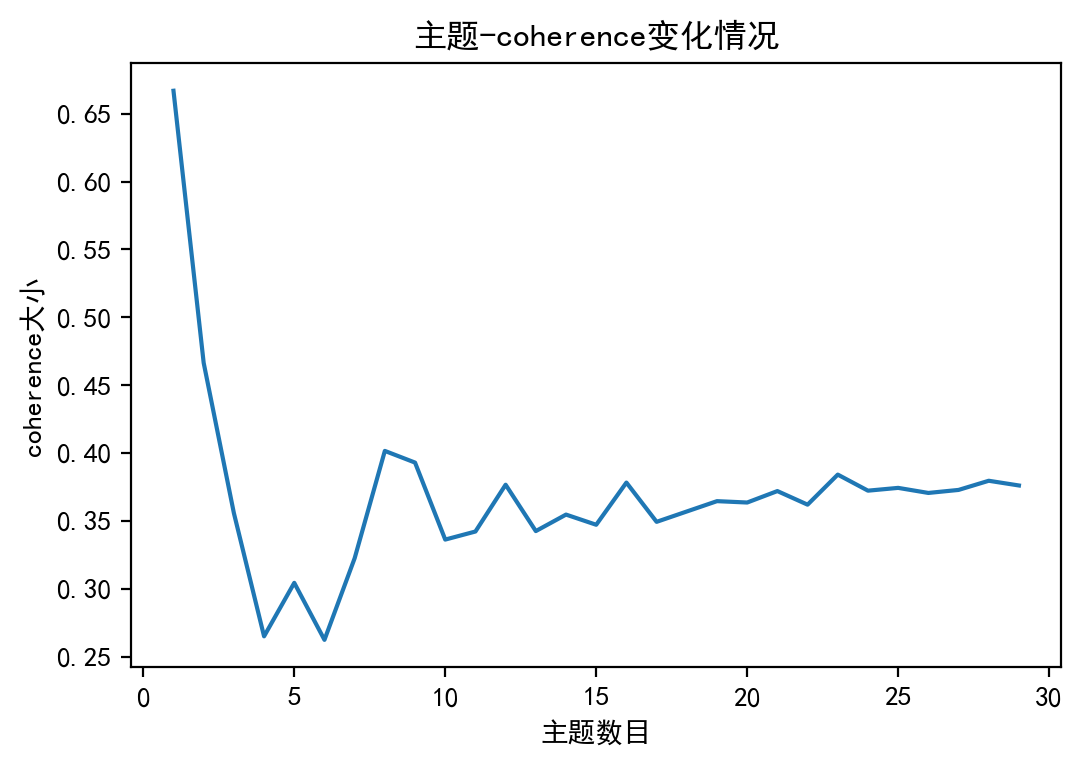

In [12]:
plt.figure(dpi=200)
plt.plot(x, y)
plt.xlabel('topic nums')
plt.ylabel('coherence')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('topic-coherence')
# plt.show()


In [15]:

dictionary = Dictionary(text)

corpus = [dictionary.doc2bow(words) for words in text]

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=100, iterations=50)
# U_Mass Coherence
ldaCM = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')


for topic in lda.print_topics(num_words=10):
    print(topic)


(0, '0.051*"redis" + 0.044*"gloutofmemory" + 0.043*"android" + 0.042*"random" + 0.041*"opengles" + 0.040*"error" + 0.038*"outofmemory" + 0.038*"drawing" + 0.038*"getting" + 0.035*"opengles20"')
(1, '0.059*"opengles20" + 0.051*"getting" + 0.051*"drawing" + 0.049*"outofmemory" + 0.048*"android" + 0.044*"error" + 0.042*"opengles" + 0.039*"random" + 0.035*"gloutofmemory" + 0.017*"xml"')
(2, '0.135*"javafx" + 0.135*"causes" + 0.135*"whileloop" + 0.135*"crash" + 0.135*"fx" + 0.134*"window" + 0.006*"android" + 0.004*"apache" + 0.004*"maven" + 0.004*"properties"')


In [16]:

plot =pyLDAvis.gensim_models.prepare(lda,corpus,dictionary, sort_topics=False)

pyLDAvis.save_html(plot, './pic/high_sim.html')

